<a href="https://colab.research.google.com/github/TheRoberto2512/DeepBrainMRI/blob/main/Dataset_(Download_%2B_Pre_Processing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6>**SOMMARIO DEL NOTEBOOK**</font>

In questo notebook sono presenti tutti i moduli relativi al download del dataset, all'analisi della distribuzione delle classi e ai vari tipi di pre-processamento. Inoltre è presente un modulo aggiuntivo per salvare una copia del dataset pre-processato su Google Drive, in modo da facilitare il caricamento sugli altri notebook senza dover rieffettuare download e/o pre-processing.


**Indice:**
*   [Installazione e import librerie](#1)
*   [Download del dataset](#2)
*   [Analisi del dataset](#3)
*   [Bilanciamento](#4)
*   [Salvataggio su Google Drive](#5)



<a name="1"></a>
# Installazioni e import librerie

In [ ]:
! pip install tensorflow-gpu==2.8.3

In [ ]:
! pip install opendatasets                        # ci avvaliamo della libreria OpenDatasets per scaricare più facilmente il dataset da kaggle

In [ ]:
from google.colab import drive, files
import matplotlib.pyplot as plt
import opendatasets as od
import tensorflow as tf
from PIL import Image
import numpy as np
import shutil
import os

In [ ]:
drive.mount("/content/drive", force_remount=True) # montiamo Google Drive per poter salvare i dataset pre-processati

Mounted at /content/drive


<font color='#c00000'>**IMPORTANTE**:</font> Qualora la cartella principale del progetto non si trovi nella home di Google Drive, personalizzare la seguente stringa!

In [ ]:
main_folder_path = '/content/drive/MyDrive/DeepBrainMRI'

<a name="2"></a>
#Download del dataset:

Inserire il file "*kaggle.json*" per poter scaricare il dataset. Fare riferimento alla <a href="https://github.com/TheRoberto2512/DeepBrainMRI?tab=readme-ov-file#installazione">sezione installazione</a> qualora non lo si avesse.

In [ ]:
print("Caricare il file kaggle.json:\n")
files.upload()

In [ ]:
od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

100%|██████████| 149M/149M [00:00<00:00, 248MB/s]


Impostiamo dei valori costanti per la corretta esecuzione del notebook.

In [ ]:
#@title Parametri di base
base_datasets_path = f"{main_folder_path}/Datasets/"

BATCH_SIZE = 32 #@param {type: "integer"}                       # specifichiamo la grandezza dei batch
IMAGE_WIDTH = 299 #@param {type: "integer"}
IMAGE_HEIGHT = 299 #@param {type: "integer"}                    # la dimensione delle immagini di default per l'EfficientNetV2S è 299×299

IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 1)

SEED = 2680 #@param {type: "integer"}                           # seme per poter replicare le stesse condizioni del dataset                                                                    # seme per il dataset

Creiamo train_data avvalendoci della funzione offerta da Keras.

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(                         # importiamo solamente il train data perché é l'unico che pre-processeremo
    directory = '/content/brain-tumor-mri-dataset/Training/',                     # directory dov'è stato scaricato il dataset
    labels='inferred',                                                            # le etichette vengono scelte in base ai nomi delle sotto-directory
    label_mode= 'categorical',                                                    # le etichette vengono codificate come verroti one-hot encoding
    color_mode='grayscale',                                                       # verrà usato un solo canale invece che 3
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),                                       # le immagini verranno ridimensionate alla dimensione scelta
    batch_size = BATCH_SIZE,                                                      # le immagini vengono divise in batch di grandezza specificata
    shuffle=False,                                                                # lascia le immagini nell'ordine di importazione
    seed=SEED,                                                                    # impostiamo un numero a caso per poter replicare le stesse condizioni
    crop_to_aspect_ratio=True,                                                    # ritaglia le immagini per mantenere il rapporto indicato
)

test_data = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/brain-tumor-mri-dataset/Testing/',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    crop_to_aspect_ratio=True,
)

class_names = train_data.class_names                                              # salviamo i nomi delle classi
tipo_dataset = 'base'                                                             # servirà per i salvataggi su Drive

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


<a name="3"></a>
#Analisi del dataset:

Funzione per visualizzare il grafico a barre per la distribuzione delle classi.

In [ ]:
def printChart(dataset, title):
  class_counts = {class_name: 0 for class_name in class_names}    # dizionario coi numeri degli elementi

  for images, labels in dataset:                                  # Conta gli elementi per ogni classe
      for label in labels:
          class_name = class_names[tf.argmax(label, axis=-1)]
          class_counts[class_name] += 1

  sizes = list(class_counts.values())
  colors = ['#d100aa', '#0070c0', '#ed7d31', '#00b050' ]          # colori per le barre

  plt.figure(figsize=(6, 6))
  plt.title(f"{title}\n", fontsize=20)

  bars = plt.bar(class_names, sizes, color=colors)
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2.0, yval, "%d" % int(yval), va='bottom', ha='center', fontsize=12)
      plt.text(bar.get_x() + bar.get_width()/2.0,  max(sizes)/2, "%.1f%% " % (int(yval)/sum(sizes)*100), fontweight='bold', color='#ffffff', fontsize=14, va='bottom', ha='center')

  plt.show()

Visualizziamo prima la distribuzione nel training set:

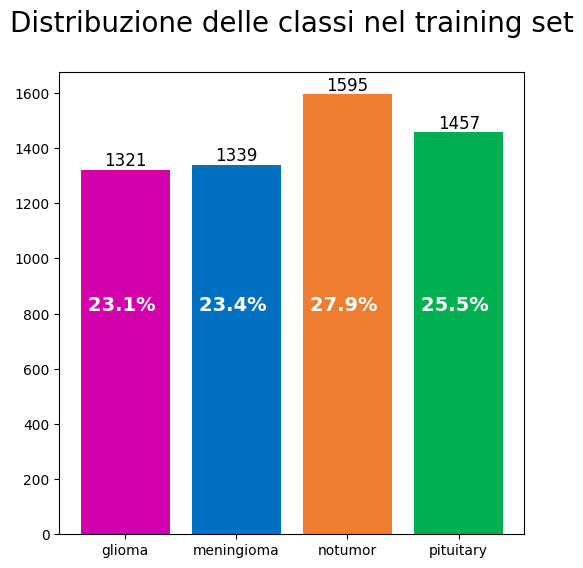

In [ ]:
printChart(train_data, "Distribuzione delle classi nel training set")

Come possiamo osservare dal grafico a barre, le classi nel training set sono leggermente sbilanciate tra loro.

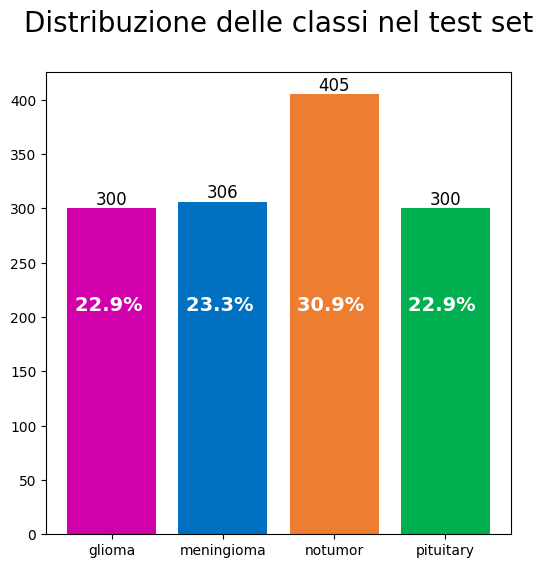

In [ ]:
printChart(test_data, "Distribuzione delle classi nel test set")

<a name="4"></a>
#Bilanciamento

Prima splittiamo il train data in più elementi (in base alla classe) per facilitarci l'undersampling e/o la data augmentation.

In [ ]:
n_class = len(class_names)                            # ricaviamo il numero delle classi
train_data_divisi = [None for i in range(n_class)]    # conterrà i diversi train_data splittati per classe
campioni_per_classe = {}                              # conterrà il numero di elementi per ogni train_data

train_data_divisi[0] = train_data.unbatch()           # unbatchamo il dataset per poterlo scorrere sequenzialmente

i, x = 0, 0                                           # variabili di utiltà

for _, labels in train_data.unbatch():                # scorriamo il dataset unbatchato (ordinato per classe)
  if labels[x] != 1:                                  # scorriamo tutta la classe partendo dalla prima
    train_data_divisi[x], train_data_divisi[x+1] = tf.keras.utils.split_dataset(train_data_divisi[x], left_size = i) # splittiamo il dataset
    campioni_per_classe[class_names[x]] = i           # salviamo il numero di campioni per quella classe
    print(f"Ho messo in train_data_divisi[{x}]: {i} elementi ({class_names[x]})")
    x+=1
    if x == (n_class-1):                              # se siamo arrivati all'ultima classe
      campioni_per_classe[class_names[x]] = len(train_data_divisi[x])
      print(f"Ho messo in train_data_divisi[{n_class-1}]: {campioni_per_classe[class_names[x]]} elementi ({class_names[x]})")
      break
    i=0
  i+=1

Ho messo in train_data_divisi[0]: 1321 elementi (glioma)
Ho messo in train_data_divisi[1]: 1339 elementi (meningioma)
Ho messo in train_data_divisi[2]: 1595 elementi (notumor)
Ho messo in train_data_divisi[3]: 1457 elementi (pituitary)


In base al tipo di bilanciamento desiderato, possiamo scegliere direttamente di eseguire una tra queste 3 sezioni per intero.

## Undersampling + Data Augmentation

In [ ]:
tipo_dataset = 'under+aug'
campioni_per_classe = dict(sorted(campioni_per_classe.items(), key=lambda item: item[1])) # ordiniamo il dizionario per valore crescente
campionamento_target = list(campioni_per_classe.values())[-2]                             # bilanciamo usando il penultimo come target
sorted_names = list(campioni_per_classe.keys())

# ordiniamo gli train_data_divisi in base al numero di elementi
for i in range(n_class-1):
  for j in range(n_class-1):
    if len(train_data_divisi[j]) > len(train_data_divisi[j+1]):
      train_data_divisi[j], train_data_divisi[j+1] = train_data_divisi[j+1], train_data_divisi[j]

for i, (k, v) in enumerate(campioni_per_classe.items()):
  bilanciamento = v - campionamento_target
  if bilanciamento > 0:
    train_data_divisi[i] = train_data_divisi[i].shuffle(v)            # shuffle degli elementi per variare l'undersampling
    train_data_divisi[i] = train_data_divisi[i].skip(bilanciamento)   # skippiamo i primi elementi
    print(f'Ho eliminato {bilanciamento} elementi da {sorted_names[i]}')

Ho eliminato 138 elementi da notumor


In [ ]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,     	    # Rotazione casuale di +/- 10 gradi
    zoom_range=0.1,        	    # Zoom casuale fino al 10%
    brightness_range=[0.8,1.2], # Regolazione della luminosità
)

In [ ]:
for i in range(len(train_data_divisi)):

  generated_imgs, generated_lbls = [], []

  if len(train_data_divisi[i]) < campionamento_target:                                # se dobbiamo generare nuove immagini
    imgs_to_gen = campionamento_target - len(train_data_divisi[i])                    # calcoliamo quante ne vanno generate
    train_data_divisi[i] = train_data_divisi[i].shuffle(len(train_data_divisi[i]), reshuffle_each_iteration = True)    # shuffle delle immagini

    for j in range(0, imgs_to_gen):
      immagine, label = next(iter(train_data_divisi[i]))                              # estraiamo un immagine e la sua label
      new_image = data_gen.random_transform(immagine.numpy())                         # generiamo l'immagine
      generated_imgs.append(new_image)
      generated_lbls.append(label.numpy())

    print(f'Ho generato {imgs_to_gen} immagini per la classe {sorted_names[i]}')
    generated_imgs = tf.convert_to_tensor(generated_imgs, dtype=tf.float32)           # convertiamo in tensori
    generated_lbls = tf.convert_to_tensor(generated_lbls, dtype=tf.float32)

    generated_data = tf.data.Dataset.from_tensor_slices((generated_imgs, generated_lbls))
    train_data_divisi[i] = train_data_divisi[i].concatenate(generated_data)
    train_data_divisi[i] = train_data_divisi[i].shuffle(campionamento_target)
    print(f'La classe {sorted_names[i]} ora dispone di {len(train_data_divisi[i])} immagini\n')

##SOLO Undersampling

In [ ]:
tipo_dataset = 'only_under'
campioni_per_classe = dict(sorted(campioni_per_classe.items(), key=lambda item: item[1])) # ordiniamo il dizionario per valore crescente
campionamento_target = list(campioni_per_classe.values())[0]                              # bilanciamo usando primo come target (classe minoritaria)
sorted_names = list(campioni_per_classe.keys())

# ordiniamo gli train_data_divisi in base al numero di elementi
for i in range(n_class-1):
  for j in range(n_class-1):
    if len(train_data_divisi[j]) > len(train_data_divisi[j+1]):
      train_data_divisi[j], train_data_divisi[j+1] = train_data_divisi[j+1], train_data_divisi[j]

for i, (k, v) in enumerate(campioni_per_classe.items()):
  bilanciamento = v - campionamento_target
  if bilanciamento > 0:
    train_data_divisi[i] = train_data_divisi[i].shuffle(v)            # shuffle degli elementi per variare l'undersampling
    train_data_divisi[i] = train_data_divisi[i].skip(bilanciamento)   # skippiamo i primi elementi
    print(f'Ho eliminato {bilanciamento} elementi da {sorted_names[i]}')

Ho eliminato 18 elementi da meningioma
Ho eliminato 136 elementi da pituitary
Ho eliminato 274 elementi da notumor


## SOLO Data Augmentation

In [ ]:
tipo_dataset = 'only_aug'
campioni_per_classe = dict(sorted(campioni_per_classe.items(), key=lambda item: item[1])) # ordiniamo il dizionario per valore crescente
campionamento_target = list(campioni_per_classe.values())[-1]                             # bilanciamo usando l'ultimo come target (classe maggioritaria)
sorted_names = list(campioni_per_classe.keys())

# ordiniamo i train_data_divisi in base al numero di elementi
for i in range(n_class-1):
  for j in range(n_class-1):
    if len(train_data_divisi[j]) > len(train_data_divisi[j+1]):
      train_data_divisi[j], train_data_divisi[j+1] = train_data_divisi[j+1], train_data_divisi[j]

In [ ]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,     	    # Rotazione casuale di +/- 10 gradi
    zoom_range=0.1,        	    # Zoom casuale fino al 10%
    brightness_range=[0.8,1.2], # Regolazione della luminosità
)

In [ ]:
for i in range(len(train_data_divisi)):
  generated_imgs, generated_lbls = [], []

  if len(train_data_divisi[i]) < campionamento_target:                                # se dobbiamo generare nuove immagini
    imgs_to_gen = campionamento_target - len(train_data_divisi[i])                    # calcoliamo quante ne vanno generate
    train_data_divisi[i] = train_data_divisi[i].shuffle(len(train_data_divisi[i]), reshuffle_each_iteration = True)    # shuffle delle immagini

    for j in range(0, imgs_to_gen):
      immagine, label = next(iter(train_data_divisi[i]))                              # estraiamo un immagine e la sua label
      new_image = data_gen.random_transform(immagine.numpy())                         # generiamo l'immagine
      generated_imgs.append(new_image)
      generated_lbls.append(label.numpy())

    print(f'Ho generato {imgs_to_gen} immagini per la classe {sorted_names[i]}')
    generated_imgs = tf.convert_to_tensor(generated_imgs, dtype=tf.float32)           # convertiamo in tensori
    generated_lbls = tf.convert_to_tensor(generated_lbls, dtype=tf.float32)

    generated_data = tf.data.Dataset.from_tensor_slices((generated_imgs, generated_lbls))
    train_data_divisi[i] = train_data_divisi[i].concatenate(generated_data)
    train_data_divisi[i] = train_data_divisi[i].shuffle(campionamento_target)
    print(f'La classe {sorted_names[i]} ora dispone di {len(train_data_divisi[i])} immagini\n')

<a name="5"></a>
# Salvataggio del dataset su Google Drive

Per salvare TUTTO il dataset non pre-processato:

In [ ]:
if not os.path.exists(base_datasets_path):                                        # se non esiste la cartella dei Datasets...
  os.makedirs(base_datasets_path)                                                 # la crea

if not os.path.exists(f"{base_datasets_path}/DATASET_BASE/"):                     # se non esiste la cartella per questo tipo di dataset...
  os.makedirs(f"{base_datasets_path}/DATASET_BASE/")                              # la crea

shutil.copytree("/content/brain-tumor-mri-dataset/", f"{base_datasets_path}/DATASET_BASE/", dirs_exist_ok=True)

Per salvare solamente un train_data pre-processato:

In [ ]:
if tipo_dataset == 'base':                                                        # il dataset base può essere salvato più facilmente con la cella sopra
  print('Usare la cella sopra per salvare il dataset senza pre-processing!')
else:
  this_dataset_folder = base_datasets_path + tipo_dataset + '/'

  if not os.path.exists(base_datasets_path):                                      # se non esiste la cartella dei Datasets...
    os.makedirs(base_datasets_path)                                               # la crea

  if not os.path.exists(this_dataset_folder):                                     # se non esiste la cartella per questo tipo di dataset...
    os.makedirs(this_dataset_folder)                                              # la crea

  for i in range(len(sorted_names)):
    if not os.path.exists(this_dataset_folder + f'{sorted_names[i]}/'):           # se non esiste la cartella per questa classe
      os.makedirs(this_dataset_folder + f'{sorted_names[i]}/')                    # la crea

    for j, (image, label) in enumerate(train_data_divisi[i]):                     # scorre il dataset immagine per immagine
      numpy_image = image.numpy()
      numpy_image = numpy_image[:,:,0]                                            # taglia l'ultima dimensione (quella dei canali)

      img = Image.fromarray(numpy_image.astype("uint8"), 'L')                     # 'L' indica che è grayscale (infatti tagliamo la dimensione dei canali)
      img.save(this_dataset_folder + f'{sorted_names[i]}/' + f'img_{j}.jpg')
      print(f'Ho salvato img_{j}.jpg dentro la cartella: {this_dataset_folder}{sorted_names[i]}/')